In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

from C60_helper_functions import find_enso_events

In [2]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=15)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43571 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/43571/status,
Dashboard: /proxy/43571/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.161:34245,Workers: 0
Dashboard: /proxy/43571/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
d=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
for i in d.variables:
    if len(i)<8:
        t='\t\t'
    else:#if len(i)<13:
        t='\t'
    try:
        print(i+t+d[i].units)
    except:
        print(i+t+'no units')

adic		mmol/m^3
alk		mmol/m^3
caco3		mmol/m^3
caco3_sediment	mmolN/m^2
det		mmol/m^3
det_sediment	mmolN/m^2
dic		mmol/m^3
ensemble	no units
export_inorg	mmolC/m^2/s
export_prod	mmolN/m^2/s
fe		mmol/m^3
no3		mmol/m^3
o2		mmol/m^3
paco2		
pco2		
phy		mmol/m^3
pprod_gross	mmolN/m^3/s
pprod_gross_2d	mmolN/m^2/s
scalar_axis	none
st_ocean	meters
stf03		mmol/m^2/s
stf07		mmol/m^2/s
stf10		mmol/m^2/s
surface_adic	mmol/m^3
surface_alk	mmol/m^3
surface_caco3	mmol/m^3
surface_det	mmol/m^3
surface_dic	mmol/m^3
surface_fe	mmol/m^3
surface_no3	mmol/m^3
surface_o2	mmol/m^3
surface_phy	mmol/m^3
surface_zoo	mmol/m^3
time		no units
total_aco2_flux	Pg/yr
total_co2_flux	Pg/yr
xt_ocean	degrees_E
yt_ocean	degrees_N
zoo		mmol/m^3


In [26]:
# LOAD NEW DATA

cafe_sst=xr.open_dataset('../processed_data/physics_ds/sst_physics_feb7.nc').sst
#rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc').sel(lon=slice(120,290),lat=slice(-40,40))
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2=(land_co2.fgco2_smoothed.sel(lon=slice(120,290),lat=slice(-40,40))/12)*1000
cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10

cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_anth_co2=cafe_co2-cafe_co2_natural

npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_cafe.nc').avg_npp.chunk('auto')
cafe_pprod=xr.open_dataset('../processed_data/physics_ds/pprod_gross_2d_bgc_feb7.nc').pprod_gross_2d


In [5]:
pwd

'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code'

In [6]:
#Check the calculation of these indexes look a bit wrong.
el_new=pd.read_csv('../processed_data/indexes/el_nino_events.csv')
la_new=pd.read_csv('../processed_data/indexes/la_nina_events.csv')
ep_new=pd.read_csv('../processed_data/indexes/ep_events.csv')
cp_new=pd.read_csv('../processed_data/indexes/cp_events.csv')

In [7]:
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')

In [8]:
#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')
nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=cafe_co2.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

In [9]:
# LOAD CAFE BGC DATA

best_ens=25

bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac

/local/v45/np1383/tmp/ipykernel_3249881/3449017216.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


,Array,Chunk
Bytes,2.27 GiB,195.23 kiB
Shape,"(731, 50, 98, 170)","(1, 3, 98, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.27 GiB,195.23 kiB
Shape,"(731, 50, 98, 170)","(1, 3, 98, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
eqpac_phys=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac_sst=eqpac_phys.sst

/local/v45/np1383/tmp/ipykernel_3249881/160556509.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


In [11]:
#Conversion to g/m2/day     /1000)*86400*-12

In [12]:
pwd

'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code'

In [13]:
# LOAD CO2 FLUX PRODUCTS
#land_co2=land_co2.fgco2_smoothed
#cafe_co2=(eqpac.stf10/1000)*86400*-12

#cafe_nat_co2=(eqpac.stf07/1000)*86400*-12

#cafe_anth_co2=((eqpac.stf10-eqpac.stf07)/1000)*86400*-12

In [14]:
import calendar
def JulianDate_to_MMDDYYY(y,jd):
        """Given a year and julian date, returns an np.datetime64 of the day"""
        month = 1
        while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
            jd = jd - calendar.monthrange(y,month)[1]
            month = month + 1
           
        jd=str(jd).zfill(2) #turn into the form 01 02 03 10 etc
        month=str(month).zfill(2)    
        
        return str(y)+'-'+month+'-'+jd
    
def add_date(ds):
        jday=int(ds.attrs['id'][5:8])
        yr=int(ds.attrs['id'][1:5])
        
        #ds.coords['JulDay'] = jday
        date=JulianDate_to_MMDDYYY(yr,jday)
        ds.coords['time'] =  np.datetime64(date)
        return ds

In [15]:

#cafe_export=eqpac.export_prod
#cafe_npp=eqpac.pprod_gross_2d

#((cafe_phy.sel(time=slice(cftime.DatetimeJulian(2000,1,1),cftime.DatetimeJulian(2000,12,1)))*6.625*12)/100)#.mean(dim='time').plot()

In [16]:
# LOAD CHL OBS
cafe_phy=((eqpac.surface_phy*6.625*12)/100)

In [17]:
tpca_sw=xr.open_dataset('../processed_data/obs/TPCA_sw_month_regrid.nc').__xarray_dataarray_variable__
tpca_mod=xr.open_dataset('../processed_data/obs/TPCA_modis_month_regrid.nc').__xarray_dataarray_variable__

# Merge TPCA
tpca_mod.name='modis_tpca'#.to_array()
tpca_sw.name='sw_tpca'
comb_tpca=xr.merge([tpca_mod,tpca_sw])#.to_array()
tpca_mean_temp=comb_tpca.to_array(dim='new').mean('new')
comb_tpca=comb_tpca.assign(tpca_mean=tpca_mean_temp)
tpca_mean=comb_tpca.tpca_mean

In [18]:
#load_and_merge_NASA_chlora()
nasa_mean = xr.open_dataset('../processed_data/obs/Nasa_merged_chlora_month_regrid.nc',chunks='auto').nasa_mean

In [61]:
def plot_cartopy_row(fig,
                     axn,
                     dat,
                     dat_mean,
                     units,
                     title,
                     units_tr=None,
                     levs=None,
                     levs_trend=None,
                     rend_conversion=None,
                     sb1=7,sb2=3,
                     extend=None,
                     cmap='viridis',
                     cmaptr='RdBu_r',
                     wu=None,wv=None, 
                     significance_stiples=False):
    '''
    Create a plotting function to make it repeatable and nicer
    colormaps should either be viridis or RdBu_r
    axis (number) will be 1,3,5,7 (plots both avg and trend at once)
     
    Unfortunately this function does the processing of mean, trends and pvals on the fly.
    Could save these if needed, but not provided here. 
    
    Example Use
    ```
    fig=plt.figure(figsize=(19*2/2.54,23*2/2.54))#(figsize=(30,15))
    sb1=7
    sb2=3



    ```
    '''
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth


    
    fr=0.03
    fs=12
    ms=10
    startday=np.datetime64('2000-01-01')
    endday=np.datetime64('2020-01-01')
    #ax1=fig.add_subplot(sb1,sb2,axn)
    # Or maybe just subplot ??
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)


    f=ax.contourf(dat.lon,dat.lat,dat.mean(dim='time')-dat_mean.mean(dim='time'),transform=ccrs.PlateCarree(),cmap=cmap,levels=levs,extend=extend) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")

    if title=='SST':
        
        lev=28.5#29.2 #rather than 28.5
        early_sst=dat.sel(time=slice('1997-01-01','2002-01-01')).mean(dim='time')#.where(co2.seamask==1)
        late_sst=dat.sel(time=slice('2015-01-01','2020-01-01')).mean(dim='time')#.where(co2.seamask==1)
       
        ax.contour(dat.lon,dat.lat,early_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='dotted',colors='k')
        
        ax.contour(dat.lon,dat.lat,late_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='solid',colors='k')
        ax.contour(dat.lon,dat.lat,dat.mean(dim='time'),transform=ccrs.PlateCarree(),levels=[25],linestyles='dashed',colors='k')
        
    
    
    
    #wu['lon'],wu['lat']=m(lo,la,wu.lon.values,wu.lat.values)
    #No windspeed vectors now
    #if title=='Wind speed':
    #      skip=(slice(None,None,4),slice(None,None,4)) #2 for NCEP 2
    #      m.quiver(lo1[skip],la1[skip],wu.mean(dim='time')[skip]/2,wv.mean(dim='time')[skip]/2,scale=90,headwidth=4.5)#,minshaft=2)

    
    
    #LETS do a t-test to see if they where there is significant differnces
    significance_stiples=False
    if significance_stiples==True:
        #Trends
        dat=dat.where(dat!=-0.9999,np.nan)
        #hm=dat.interpolate_na(dim='time').sel(time=slice(startday,endday))
        months=dat.time

        dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
        num_dates=dt_dates
        dat['time']=num_dates
        
        anom=np.concatenate(dat.T)
        mean=np.concatenate(dat_mean.T)

        pv=[]
        for i in range(anom.shape[0]):
            #print(xx[i,:])
            stat=ttest_ind(anom[i],dat_mean[i],nan_policy='omit')#linregress(time,xx[i,:])
            #print(stat)
            #tr.append(stat.slope*365)
            pv.append(stat.pvalue)

        pv=np.array(pv).reshape(len(dat.lon),len(dat.lat)).T

        hh=dat.copy()
        hh=hh.drop('time')
        hh['pval']=(['lat','lon'],pv)

        cnt=m.contourf(dat.lon,dat.lat,hh.pval,colors='none',hatches=['.'],levels=[0,0.05])
        #for c in cnt.collections:
        #    c.set_edgecolor("face")
       
    
    #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
       
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr)
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

    if axn==1:
        name='EP Events'
    elif axn==2:
        name='CP Events'
    elif axn==3:
        name='La Nina Events'
    
    
    if axn<=3:
        ax.set_title(name+'\n'+chr(ord('`')+axn)+') Anomaly: '+title,fontsize=fs)
    else:
        ax.set_title(chr(ord('`')+axn)+') Anomaly (event minus neutral): '+title,fontsize=fs)
    print(title)
    ax.tick_params(labelsize=fs)
    ax.set_aspect('auto', adjustable=None)
    

In [20]:
cluster

In [33]:
cafe_sst

<xarray.DataArray 'sst' (time: 731, lat: 140, lon: 170)>
array([[[15.605214, 15.513243, ...,       nan,       nan],
        [16.38986 , 16.300203, ...,       nan,       nan],
        ...,
        [ 8.714995, 10.162253, ..., 18.397627, 18.395304],
        [ 8.522721,  9.56701 , ..., 15.70262 , 15.78733 ]],

       [[16.606783, 16.446827, ...,       nan,       nan],
        [17.283133, 17.118671, ...,       nan,       nan],
        ...,
        [ 7.200718,  7.781426, ..., 16.862005, 17.067923],
        [ 6.996672,  7.21692 , ..., 14.418863, 14.79731 ]],

       ...,

       [[11.667186, 11.527634, ...,       nan,       nan],
        [12.367918, 12.207549, ...,       nan,       nan],
        ...,
        [18.82987 , 20.992434, ..., 24.798538, 25.05211 ],
        [19.483088, 20.749632, ..., 23.047497, 23.402773]],

       [[12.674877, 12.579859, ...,       nan,       nan],
        [13.480588, 13.405194, ...,       nan,       nan],
        ...,
        [14.799623, 17.338655, ..., 22.960443, 23.495504],
        [15.108145, 17.026308, ..., 20.787298, 21.435627]]], dtype=float32)
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    standard_name:  sea_surface_temperature
    units:          degrees C
    valid_range:    [-10. 500.]

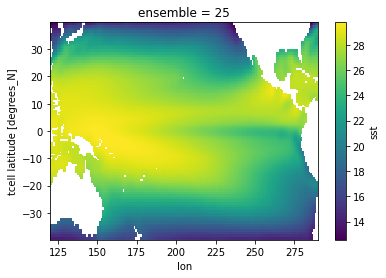

In [48]:
rey_sst.sst.where(~np.isnan(cafe_sst)).mean(dim='time').plot()

In [41]:
cafe_sst

<xarray.DataArray 'sst' (time: 731, lat: 140, lon: 170)>
array([[[15.605214, 15.513243, ...,       nan,       nan],
        [16.38986 , 16.300203, ...,       nan,       nan],
        ...,
        [ 8.714995, 10.162253, ..., 18.397627, 18.395304],
        [ 8.522721,  9.56701 , ..., 15.70262 , 15.78733 ]],

       [[16.606783, 16.446827, ...,       nan,       nan],
        [17.283133, 17.118671, ...,       nan,       nan],
        ...,
        [ 7.200718,  7.781426, ..., 16.862005, 17.067923],
        [ 6.996672,  7.21692 , ..., 14.418863, 14.79731 ]],

       ...,

       [[11.667186, 11.527634, ...,       nan,       nan],
        [12.367918, 12.207549, ...,       nan,       nan],
        ...,
        [18.82987 , 20.992434, ..., 24.798538, 25.05211 ],
        [19.483088, 20.749632, ..., 23.047497, 23.402773]],

       [[12.674877, 12.579859, ...,       nan,       nan],
        [13.480588, 13.405194, ...,       nan,       nan],
        ...,
        [14.799623, 17.338655, ..., 22.960443, 23.495504],
        [15.108145, 17.026308, ..., 20.787298, 21.435627]]], dtype=float32)
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    standard_name:  sea_surface_temperature
    units:          degrees C
    valid_range:    [-10. 500.]

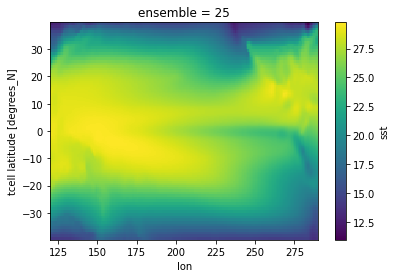

In [39]:
rey_sst.sst.mean(dim='time').where(cafe_sst.mean(dim='time')!=np.nan).plot()

Reynolds SST
Reynolds SST
Reynolds SST
CAFE60 SST
CAFE60 SST
CAFE60 SST
Landschutzer CO2 flux
Landschutzer CO2 flux
Landschutzer CO2 flux
CAFE60 CO2 flux
CAFE60 CO2 flux
CAFE60 CO2 flux
CAFE60 ANTH CO2 flux
CAFE60 ANTH CO2 flux
CAFE60 ANTH CO2 flux


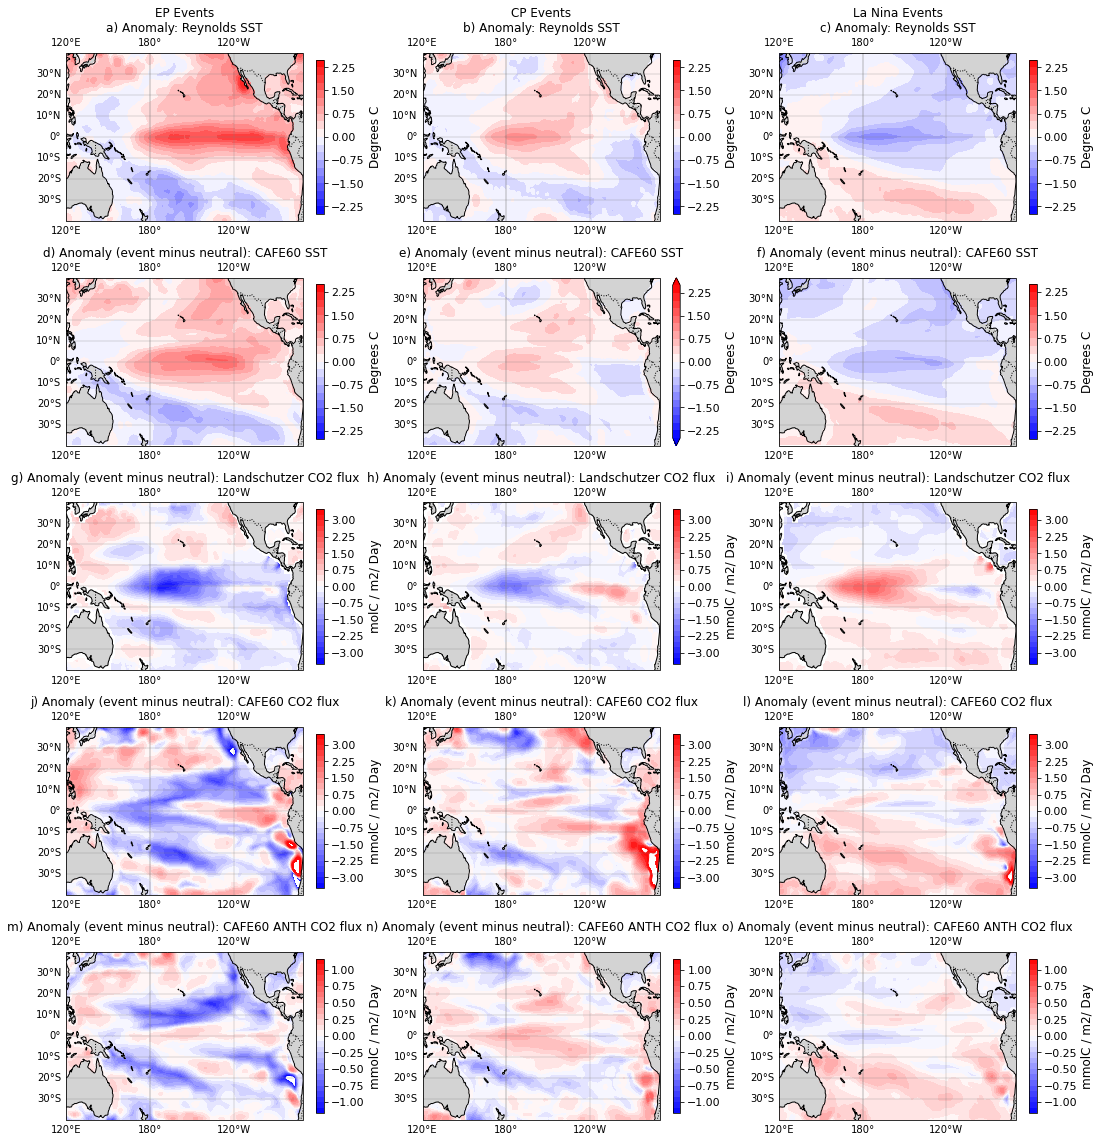

In [68]:
# DEBUG
fig=plt.figure(figsize=(15,22))#(19*2/2.54,28*2/2.54))#(figsize=(30,15))
sb1=7
sb2=3


#%% EP
sst_levs=np.arange(-2.5,2.75,0.25)
co2_levs=np.arange(-3.5,3.75,0.25)
chl_levs=np.arange(-0.1,0.11,0.01)
#Reynolds SST

plot_cartopy_row(fig,axn=1,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=ep_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=2,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=cp_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=3,
                 dat=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=nina_events),
                 dat_mean=rey_sst.sst.where(~np.isnan(cafe_sst)).sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

# CAFE60 SST
plot_cartopy_row(fig,axn=4,
                 dat=cafe_sst.sel(time=ep_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=5,
                 dat=cafe_sst.sel(time=cp_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr',extend='both')

plot_cartopy_row(fig,axn=6,
                 dat=cafe_sst.sel(time=nina_events),
                 dat_mean=cafe_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')


# LANDSCHUTZER CO2
plot_cartopy_row(fig,axn=7,
                 dat=land_co2.sel(time=ep_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='molC / m2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=8,
                 dat=land_co2.sel(time=cp_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='mmolC / m2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=9,
                 dat=land_co2.sel(time=nina_events),
                 dat_mean=land_co2.sel(time=all_dates),
                 units='mmolC / m2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

#CAFE60 CO2 flux
plot_cartopy_row(fig,axn=10,
                 dat=cafe_co2.sel(time=ep_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=11,
                 dat=cafe_co2.sel(time=cp_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=12,
                 dat=cafe_co2.sel(time=nina_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')


#CAFE60 NATURAL CO2 flux
plot_cartopy_row(fig,axn=13,
                 dat=cafe_anth_co2.sel(time=ep_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_anth_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=(co2_levs/3).round(2),
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=14,
                 dat=cafe_anth_co2.sel(time=cp_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_anth_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=(co2_levs/3).round(2),
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=15,
                 dat=cafe_anth_co2.sel(time=nina_events)*60*60*-24,#*12*1000,
                 dat_mean=cafe_anth_co2.sel(time=all_dates)*60*60*-24,#*12*1000,
                 units='mmolC / m2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=(co2_levs/3).round(2),
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')


#TPCA CHL
#plot_cartopy_row(fig,axn=16,
#                 dat=tpca_mean.sel(time=ep_events),
#                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
#                 units='mg Chl / M2',
#                 title='TPCA Chlorophyll',
#                 levs=chl_levs,
#                 sb1=sb1,
#                 sb2=sb2,
#                 #trend_conversion=1000,
#                 cmap='bwr')

#plot_cartopy_row(fig,axn=17,
#                 dat=tpca_mean.sel(time=cp_events[:-5]),
#                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
#                 units='mg Chl / M2',
#                 title='TPCA Chlorophyll',
#                 levs=chl_levs,
#                 sb1=sb1,
#                 sb2=sb2,
#                 cmap='bwr')

#plot_cartopy_row(fig,axn=18,
#                 dat=tpca_mean.sel(time=nina_events),
#                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
#                 units='mg Chl / M2',
#                 title='TPCA Chlorophyll',
#                 levs=chl_levs,
#                 sb1=sb1,
#                 sb2=sb2,
#                 cmap='bwr')


#plot_cartopy_row(fig,axn=19,
#                 dat=cafe_phy.sel(time=ep_events),
#                 dat_mean=cafe_phy.sel(time=all_dates),
#                 units='mg Chl / M2',
#                 title='CAFE60 Chlorophyll',
#                 levs=chl_levs,
##                 #trend_conversion=1000,
#                 sb1=sb1,
#                 sb2=sb2,
#                 cmap='bwr')#

#plot_cartopy_row(fig,axn=20,
#                 dat=cafe_phy.sel(time=cp_events),
#                 dat_mean=cafe_phy.sel(time=all_dates),
#                 units='mg Chl / M2',
#                 title='CAFE60 Chlorophyll',
#                 levs=chl_levs,
#                 sb1=sb1,
#                 sb2=sb2,
#                 cmap='bwr')#

#plot_cartopy_row(fig,axn=21,
#                 dat=cafe_phy.sel(time=nina_events),
#                 dat_mean=cafe_phy.sel(time=all_dates),
#                 units='mg Chl / M2',
#                 title='CAFE60 Chlorophyll',
#                 levs=chl_levs,
#                 sb1=sb1,
#                 sb2=sb2,
#                 cmap='bwr')

plt.tight_layout()

In [ ]:
# Detrended Version?

In [ ]:
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser

In [ ]:
# DEBUG
fig=plt.figure(figsize=(19*2/2.54,28*2/2.54))#(figsize=(30,15))
sb1=7
sb2=3


#%% EP
sst_levs=np.arange(-2.5,2.75,0.25)
co2_levs=np.arange(-0.04,0.045,0.005)
chl_levs=np.arange(-0.1,0.11,0.01)
#Reynolds SST

f1a=deseasonaliser(xarray_detrend(rey_sst.sst,keep_intercept_values=False))
plot_cartopy_row(fig,axn=1,
                 dat=f1a.sel(time=ep_events),
                 dat_mean=f1a.sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=2,
                 dat=f1a.sel(time=cp_events),
                 dat_mean=f1a.sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 cmap='bwr')

plot_cartopy_row(fig,axn=3,
                 dat=f1a.sel(time=nina_events),
                 dat_mean=f1a.sel(time=all_dates),
                 units='Degrees C',
                 title='Reynolds SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

# CAFE60 SST
f1b=deseasonaliser(xarray_detrend(eqpac_sst.chunk(dict(time=-1)),keep_intercept_values=False))
plot_cartopy_row(fig,axn=4,
                 dat=f1b.sel(time=ep_events),
                 dat_mean=f1b.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=5,
                 dat=f1b.sel(time=cp_events),
                 dat_mean=f1b.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=6,
                 dat=f1b.sel(time=nina_events),
                 dat_mean=f1b.sel(time=all_dates),
                 units='Degrees C',
                 title='CAFE60 SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=sst_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')


# LANDSCHUTZER CO2
f1c=deseasonaliser(xarray_detrend(land_co2,keep_intercept_values=False))
plot_cartopy_row(fig,axn=7,
                 dat=f1c.sel(time=ep_events),
                 dat_mean=f1c.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=8,
                 dat=f1c.sel(time=cp_events),
                 dat_mean=f1c.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=9,
                 dat=f1c.sel(time=nina_events),
                 dat_mean=f1c.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='Landschutzer CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

#CAFE60 CO2 flux
f1d=deseasonaliser(xarray_detrend(cafe_co2.chunk(dict(time=-1)),keep_intercept_values=False))
plot_cartopy_row(fig,axn=10,
                 dat=f1d.sel(time=ep_events),
                 dat_mean=f1d.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=11,
                 dat=f1d.sel(time=cp_events),
                 dat_mean=f1d.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=12,
                 dat=f1d.sel(time=nina_events),
                 dat_mean=f1d.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 CO2 flux',
                 levs=co2_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')


#CAFE60 NATURAL CO2 flux
f1e=deseasonaliser(xarray_detrend(cafe_anth_co2.chunk(dict(time=-1)),keep_intercept_values=False))
plot_cartopy_row(fig,axn=13,
                 dat=f1e.sel(time=ep_events),
                 dat_mean=f1e.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=co2_levs/2,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=14,
                 dat=f1e.sel(time=cp_events),
                 dat_mean=f1e.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=co2_levs/2,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=15,
                 dat=f1e.sel(time=nina_events),
                 dat_mean=f1e.sel(time=all_dates),
                 units='gC / M2/ Day',
                 title='CAFE60 ANTH CO2 flux',
                 levs=co2_levs/2,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')


#TPCA CHL
f1f=deseasonaliser(xarray_detrend(tpca_mean,keep_intercept_values=False))
plot_cartopy_row(fig,axn=16,
                 dat=f1f.sel(time=ep_events),
                 dat_mean=f1f.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 sb1=sb1,
                 sb2=sb2,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=17,
                 dat=f1f.sel(time=cp_events[:-5]),
                 dat_mean=f1f.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=18,
                 dat=f1f.sel(time=nina_events),
                 dat_mean=f1f.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')
                                                                                                                                
                                                                            
f1g=deseasonaliser(xarray_detrend(cafe_phy.chunk(dict(time=-1)),keep_intercept_values=False))                                                                                                                                              
plot_cartopy_row(fig,axn=19,
                 dat=f1g.sel(time=ep_events),
                 dat_mean=f1g.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 #trend_conversion=1000,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=20,
                 dat=f1g.sel(time=cp_events),
                 dat_mean=f1g.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plot_cartopy_row(fig,axn=21,
                 dat=f1g.sel(time=nina_events),
                 dat_mean=f1g.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 sb1=sb1,
                 sb2=sb2,
                 cmap='bwr')

plt.tight_layout()

In [ ]:
# DEBUG TEST CHL ONLY
fig=plt.figure(figsize=(19*2/2.54,23*2/2.54))#(figsize=(30,15))
sb1=7
sb2=3


#%% EP
sst_levs=np.arange(-2.5,2.75,0.25)
co2_levs=np.arange(-0.04,0.045,0.005)
chl_levs=np.arange(-0.1,0.11,0.01)
#Reynolds SST

#TPCA CHL
plot_cartopy_row(fig,axn=13,
                 dat=tpca_mean.sel(time=ep_events),
                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=14,
                 dat=tpca_mean.sel(time=cp_events[:-5]),
                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')

plot_cartopy_row(fig,axn=15,
                 dat=tpca_mean.sel(time=nina_events),
                 dat_mean=tpca_mean.sel(time=all_dates[:-5]),
                 units='mg Chl / M2',
                 title='TPCA Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')

#NASA CHL
plot_cartopy_row(fig,axn=16,
                 dat=nasa_mean.sel(time=ep_events),
                 dat_mean=nasa_mean.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='NASA Chlorophyll',
                 levs=chl_levs,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=17,
                 dat=nasa_mean.sel(time=cp_events),
                 dat_mean=nasa_mean.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='NASA Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')

plot_cartopy_row(fig,axn=18,
                 dat=nasa_mean.sel(time=nina_events),
                 dat_mean=nasa_mean.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='NASA Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')


plot_cartopy_row(fig,axn=19,
                 dat=cafe_phy.sel(time=ep_events),
                 dat_mean=cafe_phy.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=20,
                 dat=cafe_phy.sel(time=cp_events),
                 dat_mean=cafe_phy.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')

plot_cartopy_row(fig,axn=21,
                 dat=cafe_phy.sel(time=nina_events),
                 dat_mean=cafe_phy.sel(time=all_dates),
                 units='mg Chl / M2',
                 title='CAFE60 Chlorophyll',
                 levs=chl_levs,
                 cmap='bwr')

plt.tight_layout()

In [ ]:
nasa_mean.sel(time=neutral_events).mean(dim='time').plot(vmin=0,vmax=1)

In [ ]:
dat=(nasa_mean.sel(time=ep_events).mean(dim='time'))
dat_mean=nasa_mean.sel(time=neutral_events).mean(dim='time')

In [ ]:

fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth

ax = plt.subplot(1,1,1)#,projection=usemap_proj)

#ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

geodetic = ccrs.Geodetic()
plate_carree = ccrs.PlateCarree(central_longitude=180)
#lon=#transform=ccrs.PlateCarree(),
ax.contourf(dat.lon.values,dat.lat.values,dat-dat_mean,cmap='bwr',levels=np.arange(-0.1,0.11,0.01))

In [ ]:
tpca_mean

In [ ]:
nasa_mean

In [ ]:
# Starter plots have been merged now.

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event_name in ['cp_events','ep_events','nina_events']:
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')-dat.sel(time=neutral_events,method='nearest').mean(dim='time')
                 
        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-2.5,2.75,0.25))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name+' '+str(plot_counter)+str(i))
        plot_counter+=1
plt.tight_layout()
plt.show()

In [ ]:
#START

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.24,0.26,0.02),extend='both')
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=neutral_events,method='nearest').mean(dim='time')-dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.04,0.045,0.005))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' (Neutral minus event) Anomalies for: '+event_name)
        plot_counter+=1
plt.tight_layout()
plt.show()

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=(eqpac.stf10/1000)*86400*-12
        land=land_co2.fgco2_smoothed
        
        data=cafe.sel(time=times,method='nearest').mean(dim='time')-land.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.14,0.16,0.02))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Landschuter for: '+event_name)
        plot_counter+=1
plt.show()

In [ ]:
best_ens=25

phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
eqpac_phys=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac_phys.sst

In [ ]:
rey_sst.sst

In [ ]:
# DO SST NOW

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND Reynolds SST AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='viridis',levels=np.arange(18,32,1))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

In [ ]:
d

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event_name in ['cp_events','ep_events','nina_events']:
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')-dat.sel(time=neutral_events,method='nearest').mean(dim='time')
                 
        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-2.5,2.75,0.25))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name+' '+str(plot_counter)+str(i))
        plot_counter+=1
plt.tight_layout()
plt.show()

In [ ]:
neutral_events

In [ ]:
#neutral_eebtsm
#cp events, ep events, nina events
ep_events

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=eqpac_phys.sst
        reynolds=rey_sst.sst

        data=cafe.sel(time=times,method='nearest').mean(dim='time')-reynolds.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-4,5,0.5),extend='both')

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Reynolds SST for: '+event_name)
        plot_counter+=1
plt.show()